# Trans women and height distributions

## Notebook by Rachel Simone Domagalski

Note: These are quick calculations that I've done in my spare time.

### Rough overview

Given the discussion that's been happening recently about the fairness of trans women competing as women in sport, it might be useful to take a Bayesian approach to evaluate the notion of whether or not trans women are dominating women's sports. This calculation potentially useful given the influence of height on athletic ability and the rhetoric claiming that tall trans women are going to be dominating women's sports. In this notebook, I'm calculating a very rough estimate of the percentage of women at a certain height that are trans. This isn't a super rigorous calculation, just a quick ballpark estimate.

Bayes theorem is $$P(A|B) = P(B|A) P(A)/P(B)$$
where $$P(B) = P(B|A)P(A) + P(B|!A)P(!A)$$
If we label the probability a woman is trans as $P(TW)$, the probability that a woman is cis as $P(CW) = 1-P(TW)$ and the probability that a woman is a minimum height as $P(H\ge H_{min})$, then the probability that a woman is trans given she's at least a certain height is $$
P(TW|H\ge H_{min}) = \frac{P(H\ge H_{min}|TW)P(TW)}{P(H\ge H_{min}|TW)P(TW)+P(H\ge H_{min}|CW)P(CW)}
$$

I'm going to assume that population height is Gaussian distributed. I should repeat that this is a ballpark calculation. The probability density function of the Gaussian distribution is $$
PDF(x|\mu,\sigma) = \frac{1}{\sqrt{2\sigma^2}}\exp\left(-\frac{\left(x-\mu\right)^2}{2\sigma^2}\right)
$$

The corresponding cumulative density function (CDF), which gives the probability of being *less* than some value $x$, is $$
CDF(x|\mu,\sigma) = \int_{-\infty}^x PDF(x'|\mu,\sigma)dx' = \frac{1}{2}\left(1 + erf\left(\frac{x-\mu}{\sqrt{2\sigma^2}}\right)\right)
$$

Naturally, the probability of being greater than some value $x$ is equal to $1 - CDF(x|\mu,\sigma)$.

### OK, nice equations, what are the numbers?

Note: I'm using data for the United States here. Data for other countries might yield different results.

For height data, I used CDC data here: https://www.cdc.gov/nchs/data/series/sr_03/sr03_039.pdf  
More information can be found here: https://www.cdc.gov/nchs/fastats/body-measurements.htm  

If we restrict this analysis to trans women who transitioned after puberty, then despite the fact that trans women are women, the height distributions of trans women should be similar to the height distributions of cis men. While hormone replacement therapy is really powerful and does great things, its effect on height is limited on trans women that have had to endure the puberty that AMAB people go through.

The CDC reports mean heights for men and women over the age of 20, the standard error of the mean, and the amount of people in the data set. The standard error on the mean is $$
\sigma_{\bar{x}} = \frac{\sigma}{\sqrt{n}}
$$

The standard deviation of the data can then be computed from the reported results: $$
\sigma = \sigma_{\bar{x}}{\sqrt{n}} $$

The other necessary piece of data required for this analysis is the percentage of the population is trans. For this, the 2016 Williams institute data will be used: https://williamsinstitute.law.ucla.edu/wp-content/uploads/How-Many-Adults-Identify-as-Transgender-in-the-United-States.pdf

The Williams Institute study reports that 0.6% of adults in the United States are trans.


In [1]:
from typing import NamedTuple

import numpy as np
import scipy as sp
import scipy.special as ss
import matplotlib.pyplot as plt

class Parameters(NamedTuple):
    cis_w_mean: float
    cis_w_stddev: float
    trans_w_mean: float
    trans_w_stddev: float
    percent_trans: float

# Heights in centimeters, taken from tables 9 and 11 in the CDC PDF linked above
usa_n_amab = 5547
usa_n_afab = 5232
usa = Parameters(
    cis_w_mean = 161.8,
    cis_w_stddev = 0.21*np.sqrt(usa_n_afab),
    trans_w_mean = 175.7,
    trans_w_stddev = 0.21*np.sqrt(usa_n_amab),
    # Williams institute
    percent_trans = 0.006,
)

# unit conversion
cm_per_in = 2.54
cm_per_ft = cm_per_in*12

In [2]:
# define some quick math functions
def norm_gaussian_pdf(x, mean: float = 0.0, sigma: float = 1.0):
    scale = 1.0/np.sqrt(2*np.pi*sigma**2)
    exp = np.exp(-0.5*((x - mean)/sigma)**2)
    return scale*exp

def norm_gaussian_cdf(x, mean: float = 0.0, sigma: float = 1.0):
    """
    Cumulative distribution function
    """
    erf = ss.erf((x-mean)/(sigma*np.sqrt(2.)))
    return 0.5*(1. + erf)

def gaussian_integral(lower_bound, upper_bound, mean: float = 0.0, sigma: float = 1.0):
    """
    integrate a gaussian PDF between two bounds.
    probability of being within some finite range.
    """
    bounds = np.array([lower_bound, upper_bound])
    integral_vals = norm_gaussian_cdf(bounds, mean, sigma)
    return integral_vals[1] - integral_vals[0]

def prob_trans_given_min_height(params: Parameters, height: float) -> float:
    """
    Get the probablity that a woman is trans given that she is some minimum height.
    That is, what's the probability that a woman is trans if she's taller than six feet?
    P(T) + P(C) = 1
    P(T|H) = P(H|T)*P(T)/P(H)
    P(H) = P(H|T)*P(T) + P(H|C)*P(C)
    """
    # Given that the CDF for height is the probability of being less than a given height,
    # the probability of being greater than a given height is 1 - CDF.
    prob_taller_cis = 1.0 - norm_gaussian_cdf(height, params.cis_w_mean, params.cis_w_stddev)
    prob_taller_trans = 1.0 - norm_gaussian_cdf(height, params.trans_w_mean, params.trans_w_stddev)

    # 0.6% population is trans
    prob_h = prob_taller_trans*params.percent_trans + prob_taller_cis*(1.0 - params.percent_trans)
    prob_trans = prob_taller_trans*params.percent_trans/prob_h
    return prob_trans

def prob_trans_given_height_range(params: Parameters, height: float, h_range: float = cm_per_in) -> float:
    """
    Functioning for limiting height between a certain symmetric range.
    Default range: one inch.
    """
    lower_bound = height - h_range/2.
    upper_bound = height + h_range/2.

    # 
    prob_range_cis = gaussian_integral(lower_bound, upper_bound, params.cis_w_mean, params.cis_w_stddev)
    prob_range_trans = gaussian_integral(lower_bound, upper_bound, trans_w_mean, params.trans_w_stddev)

    # 0.6% population is trans
    prob_h = prob_range_trans*params.percent_trans + prob_range_cis*(1.0 - params.percent_trans)
    prob_trans = prob_range_trans*params.percent_trans/prob_h
    return prob_trans


In [3]:
%matplotlib inline

# Here is the approximate normalized height distribution of cis women and trans women who transitioned after puberty.

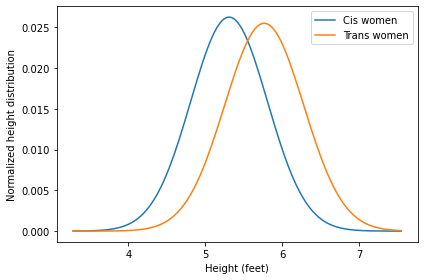

In [4]:
# Calculation axis
height_cm = np.arange(100, 231) # tallest woman is about 231 cm
height_ft = height_cm/cm_per_ft

def plot_height_dist(params: Parameters):
    global height_cm
    global height_ft
    
    trans_dist = norm_gaussian_pdf(height_cm, params.trans_w_mean, params.trans_w_stddev)
    cis_dist = norm_gaussian_pdf(height_cm, params.cis_w_mean, params.cis_w_stddev)

    # height distribution plots
    plt.figure()
    plt.plot(height_ft, cis_dist, label='Cis women')
    plt.plot(height_ft, trans_dist, label='Trans women')
    plt.xlabel('Height (feet)')
    plt.ylabel('Normalized height distribution')
    plt.legend()
    plt.tight_layout()
    
plot_height_dist(usa)

# What percentange of women above six feet are trans?

Using Bayes theorem, we can calculate the ratio of trans women to all women for women above a given height. Only about two percent of women above six feet are trans. So, when it comes to trans women competing as women in athletic competitions where being tall helps out, most women competing will likely be cis, since cis women outnumber trans women at all heights. It should be noted that at very large heights like over 6.6 feet or seven feet, calculations can start running into low-number statistics.

Percentange of women over six feet that are trans: 2.3 %


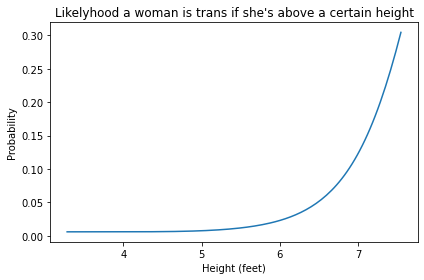

In [5]:
def plot_over_height(params: Parameters):
    prob_trans_min_h = prob_trans_given_min_height(params, height_cm)
    
    plt.figure()
    plt.plot(height_ft, prob_trans_min_h)
    plt.xlabel('Height (feet)')
    plt.ylabel('Probability')
    plt.title('Likelyhood a woman is trans if she\'s above a certain height')
    plt.tight_layout()

    six_feet = 100*prob_trans_given_min_height(params, 6*cm_per_ft)
    print('Percentange of women over six feet that are trans:', round(six_feet, 1), '%')
    
plot_over_height(usa)

### So, are tall trans women dominating women's sports?

No. While trans women who transitioned after puberty are likely going to be taller than cis women, when it comes to sports that favor height, the overwhelming majority of women participating are going to be cis. Trans women don't even become even 10% of the population of women above a minimum height until that height minimum is around seven feet, and even in that case, they are a minority among an already small minority (women over seven feet). The overwhelming majority of women who are considered tall by society are cis women, and sports that favor tall women are going to be dominated by tall cis women. 

### OK, that was just the USA's stats. What about stats for the world?

World stats are generally listed by country and it's likely non-trivial to aggregate them. Fortunately, someone did do some aggregations and have published them here: https://ourworldindata.org/human-height#height-is-normally-distributed

These are their reported aggregations for Europe, North America, East Asia, and Australia:

AFAB average height: 164.7cm

AFAB standard deviation: 7.07cm

AMAB average height: 178.4

AMAB standard deviation: 7.59cm

For the global population of trans people, that's harder to estimate and I'm going to provisionally use a value of 0.2%. There might be better numbers, but that's probably a reasonable order of magnitude for now.

Percentange of women over six feet that are trans: 9.9 %


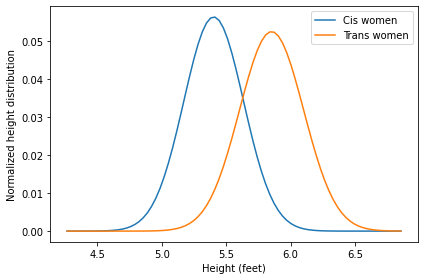

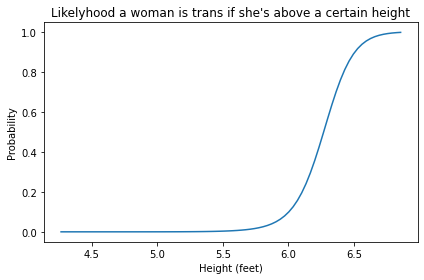

In [6]:
world = Parameters(
    cis_w_mean = 164.7,
    cis_w_stddev = 7.07,
    trans_w_mean = 178.4,
    trans_w_stddev = 7.59,
    # Provisional
    percent_trans = 0.002,
)

height_cm = np.arange(130, 210)
height_ft = height_cm/cm_per_ft

plot_height_dist(world)
plot_over_height(world)

So, it appears that if a woman anywhere around a lot of the globe is above 6 feet, there's a one in ten chance that she's trans. This might be misleading though, as different countries have height averages that vary. It's likely better to use national statistics than global statistics to determine the probability a woman is trans given her height since populations aren't spread uniformly.